In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from eng_analysis import gauss_legendre2, runge_kutta, CubicSpline, newton_raphson

plt.style.use('../maroon_ipynb.mplstyle')

Additions to the source code can be found [here](https://github.com/gabemorris12/eng_analysis).

\pagebreak
\tableofcontents
\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 8213 & Homework 4 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 1
Compute the approximate value of 

$$
\int_{-1}^1 \int_{-1}^1 e^{-\left(x^2+y^2\right)} d x d y
$$

using a Gauss-Legendre quadrature. What integration order is necessary to get the answer accurate to 6 decimal places.

## Solution

The analytical solution can be found using `sympy`.

In [2]:
x, y = sp.symbols('x y')
prob = sp.Integral(sp.exp(-x**2 - y**2), (x, -1, 1), (y, -1, 1))
prob

Integral(exp(-x**2 - y**2), (x, -1, 1), (y, -1, 1))

In [3]:
ana = prob.doit().n()
ana

2.23098514140413

The Gauss-Legendre quadrature is determined by getting the nodes and weights up to some order and applying the following relationship:

$$
I=\int_{-1}^1 \sum_{i=0}^n A_i f\left(\xi_i, \eta\right) d \eta=\sum_{j=0}^n A_j\left[\sum_{i=0}^n A_i f\left(\xi_i, \eta_j\right)\right]
$$

This process is shown in the `gauss_legendre2` function.

In [4]:
f = lambda x_, y_: np.exp(-x_**2 - y_**2)
x = [-1, 1, 1, -1]
y = [-1, -1, 1, 1]
m = 2
sol = 0

while abs(sol - float(ana)) >= 1e-6:
    m += 1
    sol = gauss_legendre2(f, x, y, m)

sol

2.230985210842258

In [5]:
m

7

As seen above, an order of $m=7$ will result in a value within 6 decimal places.

\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 8213 & Homework 4 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 2
A ball of mass $m=0.25\,kg$ is launched with an initial velocity $v_0=50\,m/s$ at an angle of $30^\circ$ above the horizontal. Assuming the drag force acting on the ball is given by $F_D=C_Dv^{3/2}$, the equations describing the motion in the horizontal and vertical directions are

$$\begin{cases}
\ddot{x}=-\frac{C_D}{m}\dot{x}\sqrt{v} \\
\ddot{y}=-\frac{C_D}{m}\dot{y}\sqrt{v} - g
\end{cases}$$

where $v$ is the magnitude of the velocity ($v=\sqrt{\dot{x}^2+\dot{y}^2}$). Using the Runge-Kutta method, determine the time before the ball hits the ground and how far away it lands from where it was launched. Use $C_d=0.03\,\frac{kg}{\sqrt{ms}}$ and $g=9.80665\,m/s^2$.

## Solution
We need to first put this system in the state variable form by transforming it into a system of only first order differential equations. This can all be done symbolically through `sympy`. The initial velocity will need to be broken down into its vector components, and the greatest way to this is through Euler's Identity.

In [6]:
v0 = 50*np.exp(1j*np.deg2rad(30))  # complex number ... real part is the x component and the imaginary is the y component

t, CD, m, g = sp.symbols('t C_D m g')
x0, y0 = sp.Function('x0')(t), sp.Function('y0')(t)

sub_values = [
    (CD, sp.S('0.03')),
    (m, sp.S('0.25')),
    (g, sp.S('9.80665'))
]

v = sp.sqrt(x0.diff()**2 + y0.diff()**2)
eq1 = sp.Eq(x0.diff(t, 2), -CD/m*x0.diff()*sp.sqrt(v))
eq2 = sp.Eq(y0.diff(t, 2), -CD/m*y0.diff()*sp.sqrt(v) - g)
display(eq1, eq2)

Eq(Derivative(x0(t), (t, 2)), -C_D*(Derivative(x0(t), t)**2 + Derivative(y0(t), t)**2)**(1/4)*Derivative(x0(t), t)/m)

Eq(Derivative(y0(t), (t, 2)), -C_D*(Derivative(x0(t), t)**2 + Derivative(y0(t), t)**2)**(1/4)*Derivative(y0(t), t)/m - g)

In [7]:
# Putting it into the state variable form
x1, y1 = sp.Function('x1')(t), sp.Function('y1')(t)

eq3 = sp.Eq(x0.diff(), x1)
eq4 = sp.Eq(y0.diff(), y1)

sub_states = [
    (x0.diff(t, 2), x1.diff()),
    (x0.diff(), x1),
    (y0.diff(t, 2), y1.diff()),
    (y0.diff(), y1)
]

eq1 = eq1.subs(sub_states)
eq2 = eq2.subs(sub_states)

state_sol = sp.solve([eq1, eq2, eq3, eq4], [x0.diff(), x1.diff(), y0.diff(), y1.diff()], dict=True)[0]
for key, value in state_sol.items(): display(sp.Eq(key, value))

Eq(Derivative(x0(t), t), x1(t))

Eq(Derivative(x1(t), t), -C_D*(x1(t)**2 + y1(t)**2)**(1/4)*x1(t)/m)

Eq(Derivative(y0(t), t), y1(t))

Eq(Derivative(y1(t), t), -C_D*(x1(t)**2 + y1(t)**2)**(1/4)*y1(t)/m - g)

In [8]:
# With values substituted
for key, value in state_sol.items():
    v = value.subs(sub_values).simplify()
    display(sp.Eq(key, v))

Eq(Derivative(x0(t), t), x1(t))

Eq(Derivative(x1(t), t), -0.12*(x1(t)**2 + y1(t)**2)**(1/4)*x1(t))

Eq(Derivative(y0(t), t), y1(t))

Eq(Derivative(y1(t), t), -0.12*(x1(t)**2 + y1(t)**2)**(1/4)*y1(t) - 9.80665)

We can now implement the Runge-Kutta method to solve this problem.

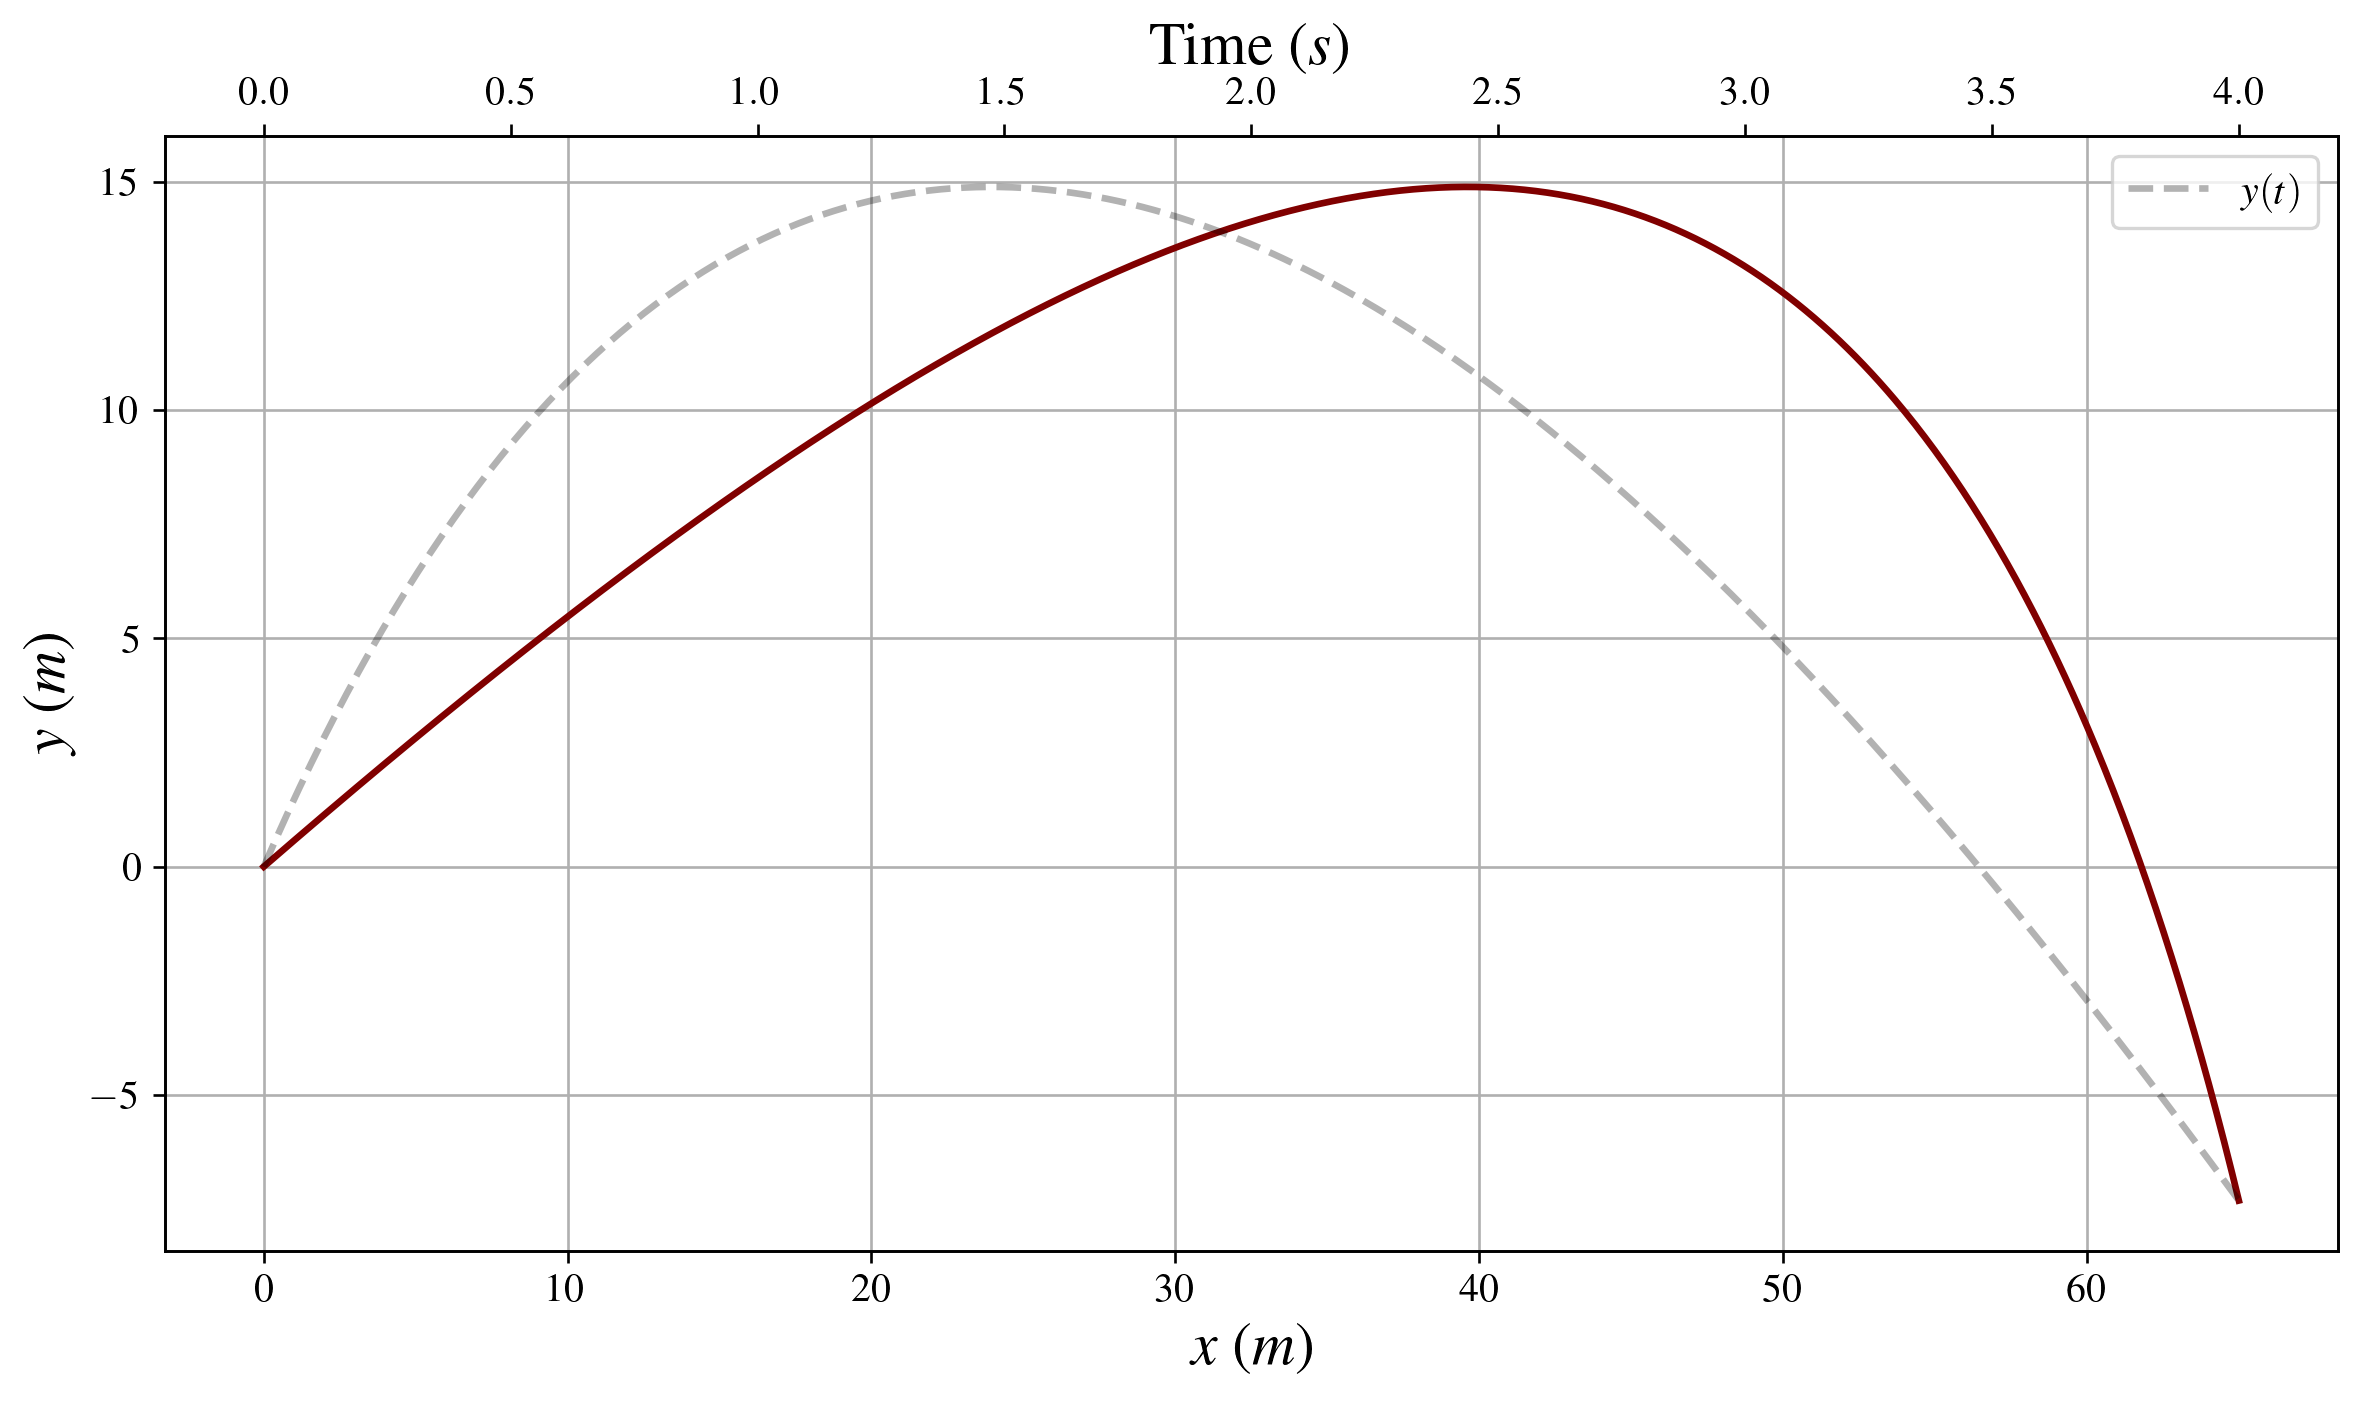

In [9]:
def state_vars(z, _):
    x0_, x1_, y0_, y1_ = z
    return [
        x1_,
        -0.12*(x1_**2 + y1_**2)**0.25*x1_,
        y1_,
        -0.12*(x1_**2 + y1_**2)**0.25*y1_ - 9.80665
    ]

t_array = np.linspace(0, 4, 500)
sol = runge_kutta(state_vars, (0, np.real(v0), 0, np.imag(v0)), t_array)
x_points, y_points = sol[0], sol[2]

fig, ax = plt.subplots()
ax2 = ax.twiny()
ax2.grid(False)
ax.set_xlabel('$x$ ($m$)')
ax.set_ylabel('$y$ ($m$)')
ax2.set_xlabel('Time ($s$)')

ax.plot(x_points, y_points)
ax2.plot(t_array, y_points, ls='--', color='black', alpha=0.3, label='$y(t)$')
ax2.legend()
plt.show()

The time is takes is close to 3.5 seconds as seen in the graph. Since we have the time points and the y points, we can make a cubic spline function, then use the Newton Raphson method to determine the actual value.

In [10]:
spline_y = CubicSpline(t_array, y_points)
t_ground = newton_raphson(spline_y, [3.5])[0]
t_ground

3.473241346676332

It takes $t=3.47$ seconds till it hits the ground.

In [11]:
# Finding the horizontal distance (close to 60)
spline_x = CubicSpline(t_array, x_points)
spline_x(t_ground)

61.80007065961908

The horizontal distance is $61.8\,m$.

\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 8213 & Homework 4 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 3
The bar ABC is attached to the vertical rod with a horizontal pin.

![Figure 1](f1.PNG)

The assembly is free to rotate about the axis of the rod. Ignoring friction, the equations of motion for the system are:

$$\begin{cases}
\ddot{\theta}=\dot{\phi}^2\sin(\theta)\cos(\theta) \\
\ddot{\phi}=-2\dot{\theta}\dot{\phi}\cot(\theta)
\end{cases}$$

The system has initial conditions as follows: $\theta(0)=\frac{\pi}{12}\,rad$, $\dot{\theta}=0$, $\phi(0)=0$, and $\dot{\phi}(0)=20\,\frac{rad}{s}$.

Find a numerical solution for the system using the adaptive Runge-Kutta method for $t=0$ to $t=1.5$ seconds and plot $\dot{\phi}(t)$.

## Solution
Just as before, the system needs to be placed in the state variable form.

In [12]:
th0, phi0 = sp.Function(r'\theta_0')(t), sp.Function(r'\phi_0')(t)

eq1 = sp.Eq(th0.diff(t, 2), phi0.diff()**2*sp.sin(th0)*sp.cos(th0))
eq2 = sp.Eq(phi0.diff(t, 2), -2*th0.diff()*phi0.diff()*(1/sp.tan(th0)))
display(eq1, eq2)

Eq(Derivative(\theta_0(t), (t, 2)), sin(\theta_0(t))*cos(\theta_0(t))*Derivative(\phi_0(t), t)**2)

Eq(Derivative(\phi_0(t), (t, 2)), -2*Derivative(\phi_0(t), t)*Derivative(\theta_0(t), t)/tan(\theta_0(t)))

In [13]:
th1, phi1 = sp.Function(r'\theta_1')(t), sp.Function(r'\phi_1')(t)

eq3 = sp.Eq(th0.diff(), th1)
eq4 = sp.Eq(phi0.diff(), phi1)

sub_states = [
    (th0.diff(t, 2), th1.diff()),
    (th0.diff(), th1),
    (phi0.diff(t, 2), phi1.diff()),
    (phi0.diff(), phi1)
]

eq1 = eq1.subs(sub_states)
eq2 = eq2.subs(sub_states)

state_sol = sp.solve([eq1, eq2, eq3, eq4], [th0.diff(), th1.diff(), phi0.diff(), phi1.diff()], dict=True)[0]
for key, value in state_sol.items(): display(sp.Eq(key, value))

Eq(Derivative(\phi_0(t), t), \phi_1(t))

Eq(Derivative(\phi_1(t), t), -2*\phi_1(t)*\theta_1(t)/tan(\theta_0(t)))

Eq(Derivative(\theta_0(t), t), \theta_1(t))

Eq(Derivative(\theta_1(t), t), \phi_1(t)**2*sin(\theta_0(t))*cos(\theta_0(t)))

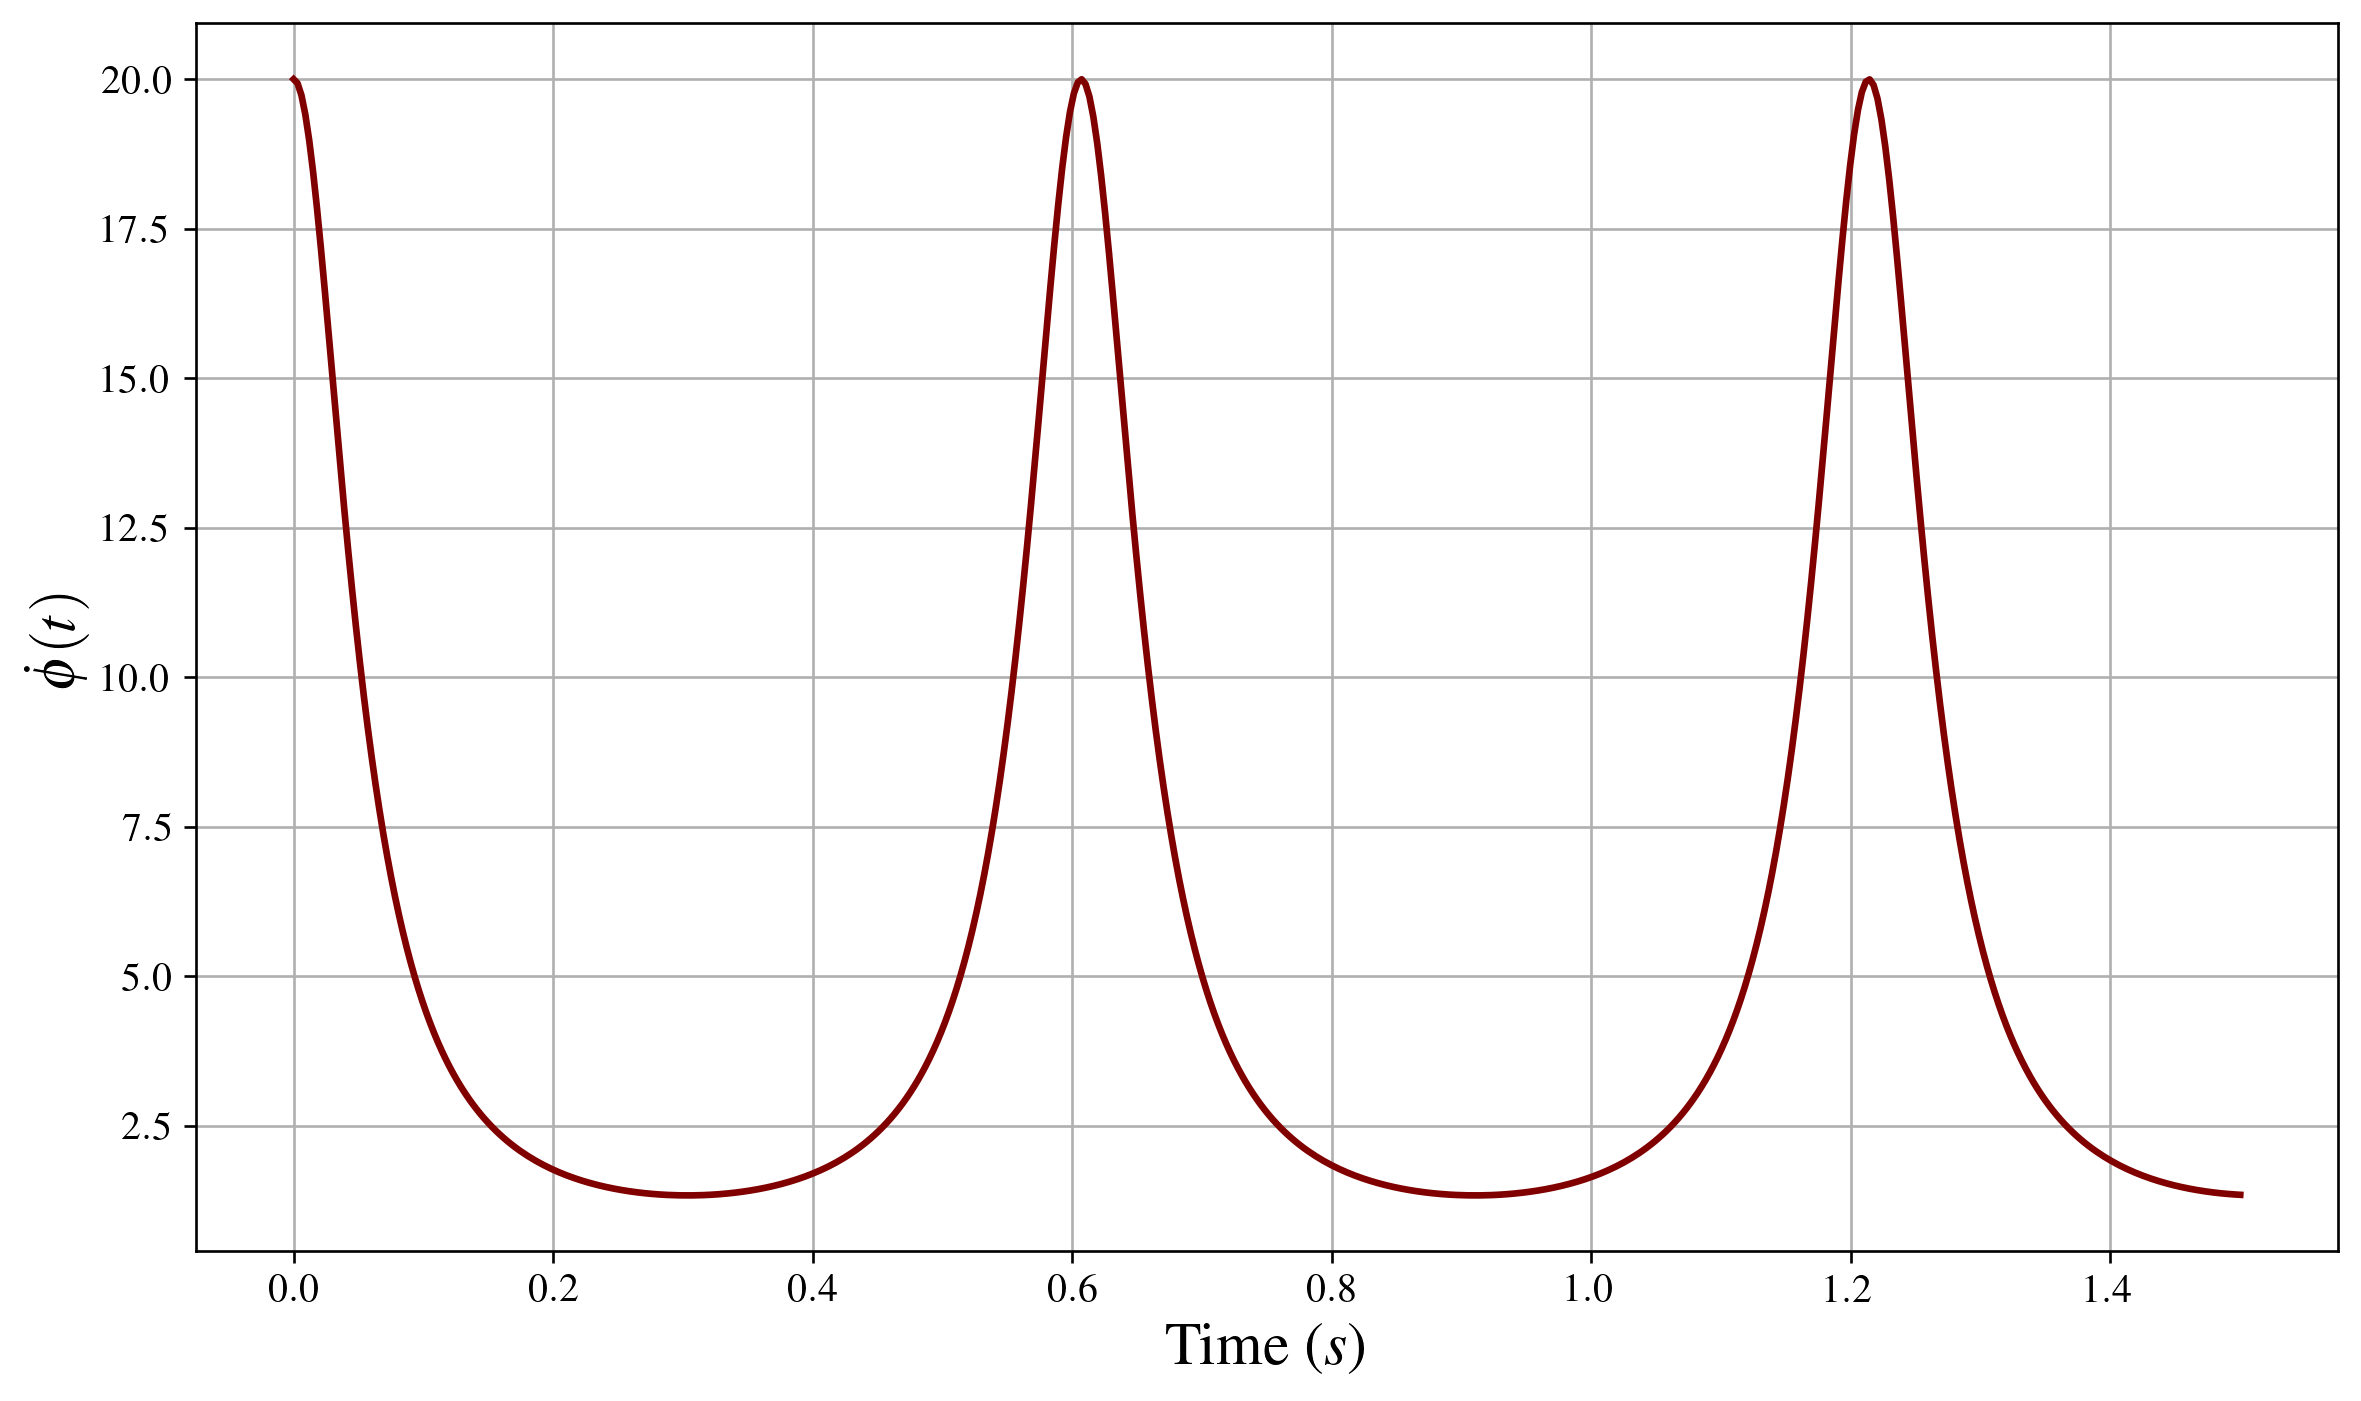

In [14]:
def state_vars(z, _):
    p0, p1, t0, t1 = z
    return [
        p1,
        -2*p1*t1/np.tan(t0),
        t1,
        p1**2*np.sin(t0)*np.cos(t0)
    ]

t_array = np.linspace(0, 1.5, 500)
sol = runge_kutta(state_vars, (0, 20, np.pi/12, 0), t_array)

plt.plot(t_array, sol[1])
plt.xlabel('Time ($s$)')
plt.ylabel('$\dot{\phi}(t)$')
plt.show()